# NREL - HSDS Data Export

This notebook demonstrates data export from the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit and National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [14]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import dateutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
# sys.path.append('../bin')
# convenience functions
from util import WTK_idx, NSRDB_idx, datetimeIndex

[WTK](#WIND-Toolkit-(WTK)) | [NSRDB](#National-Solar-Radiation-Database-(NSRDB))

## WIND Toolkit (WTK)
### Single Multivariate Timeseries

In [62]:
wtk = h5pyd.File("/nrel/wtk-us.h5", 'r')  
list(wtk)

['inversemoninobukhovlength_2m',
 'status',
 'windspeed_10m',
 'temperature_80m',
 'temperature_160m',
 'temperature_200m',
 'pressure_200m',
 'DIF',
 'temperature_10m',
 'winddirection_120m',
 'windspeed_120m',
 'windspeed_140m',
 'temperature_60m',
 'relativehumidity_2m',
 'windspeed_200m',
 'temperature_140m',
 'precipitationrate_0m',
 'winddirection_160m',
 'pressure_0m',
 'GHI',
 'windspeed_80m',
 'winddirection_100m',
 'temperature_2m',
 'temperature_40m',
 'coordinates',
 'winddirection_60m',
 'windspeed_160m',
 'winddirection_40m',
 'winddirection_10m',
 'DNI',
 'winddirection_200m',
 'windspeed_60m',
 'datetime',
 'pressure_100m',
 'windspeed_40m',
 'temperature_120m',
 'windspeed_100m',
 'winddirection_140m',
 'temperature_100m',
 'winddirection_80m']

The following code fetches daily timeseries data for a given lat/lon for three variables.

In [16]:
LongsPeak_idx = WTK_idx(wtk, (40.2549, -105.6160))
LongsPeak_idx

(921, 1093)

In [17]:
%time df = pd.DataFrame({"windspeed_100m": wtk['windspeed_100m'][:, LongsPeak_idx[0], LongsPeak_idx[1]],\
                         "winddirection_100m": wtk['winddirection_100m'][:, LongsPeak_idx[0], LongsPeak_idx[1]]},\
                         index=map(dateutil.parser.parse, wtk["datetime"][:]))
df.index.name = 'datetime'
df.head()

Wall time: 32.2 s


,windspeed_100m,winddirection_100m
datetime,,
2007-01-01 00:00:00,9.109772,266.184875
2007-01-01 01:00:00,10.260323,257.653748
2007-01-01 02:00:00,11.548203,252.830597
2007-01-01 03:00:00,11.844231,251.188080
2007-01-01 04:00:00,12.570572,251.193573


In [18]:
# save data to csv
df.to_csv('longspeak_wtk.csv')

### All Within Bounding Box

In [19]:
def indicesForBBox(wtk, lat_range, lon_range):
    xmin = None
    xmax = None
    ymin = None
    ymax = None
    for i in [0,1]:
        for j in [0,1]:
            yx = WTK_idx(wtk, (lat_range[i], lon_range[j]))
            if xmin is None or yx[1] < xmin:
                xmin = yx[1]
            if xmax is None or yx[1] > xmax:
                xmax = yx[1]
            if ymin is None or yx[0] < ymin:
                ymin = yx[0]
            if ymax is None or yx[0] > ymax:
                ymax = yx[0]
    return ([xmin, xmax], [ymin, ymax])

# This bounding box is the state of Colorado, more or less
(x_range,y_range) = indicesForBBox(wtk, [36.96744946416934, 41.02964338716638],
                                   [-109.05029296875, -102.0849609375])

print("x range for Colorado = (%d,%d)" % (x_range[0], x_range[1]))
print("y range for Colorado = (%d,%d)" % (y_range[0], y_range[1]))

x range for Colorado = (924,1241)
y range for Colorado = (729,982)


In [63]:
# Get every other windspeed measurement within this box for a given time step
dtdf = datetimeIndex(wtk)
dset = wtk['windspeed_100m']
timestep = dtdf.loc[dtdf.datetime == '2012-04-01 12:00:00'].index[0]
%time data = dset[timestep, y_range[0]:y_range[1]:2, x_range[0]:x_range[1]:2]  # :2 means every second point
dset2 = wtk['winddirection_100m']
data2 = dset2[timestep, y_range[0]:y_range[1]:2, x_range[0]:x_range[1]:2]  # :2 means every second point

Wall time: 758 ms


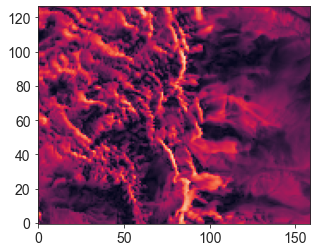

In [64]:
plt.imshow(data, origin="lower")

In [22]:
print( "There are ...")
print( "  %d points within this box a 2km resolution" % ((x_range[1] - x_range[0]) * (y_range[1] - y_range[0]),))
print( "  %d points within this box at 4km resolution" % ((x_range[1] - x_range[0]) / 2 * (y_range[1] - y_range[0]) / 2,))
print( "  %d points within this box at 8km resolution" % ((x_range[1] - x_range[0]) / 4 * (y_range[1] - y_range[0]) / 4,))
print( "  %d points within this box at 16km resolution" % ((x_range[1] - x_range[0]) / 8 * (y_range[1] - y_range[0]) / 8,))

There are ...
  80201 points within this box a 2km resolution
  20050 points within this box at 4km resolution
  5012 points within this box at 8km resolution
  1253 points within this box at 16km resolution


In [23]:
data.shape

(127, 159)

In [65]:
ua = np.multiply(data[:100,:100], np.cos(np.radians(data2[:100,:100]+np.pi/2)))
va = np.multiply(data[:100,:100], np.sin(np.radians(data2[:100,:100]+np.pi/2)))

In [25]:
ua.shape

(100, 100)

In [66]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

def conv_layer_2d(x, filter_shape, stride, trainable=True):
    W = tf.get_variable(
        name='weight',
        shape=filter_shape,
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    b = tf.get_variable(
        name='bias',
        shape=[filter_shape[-1]],
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    x = tf.nn.bias_add(tf.nn.conv2d(
        input=x,
        filter=W,
        strides=[1, stride, stride, 1],
        padding='SAME'), b)

    return x

def deconv_layer_2d(x, filter_shape, output_shape, stride, trainable=True):
    x = tf.pad(x, [[0,0], [3,3], [3,3], [0,0]], mode='reflect')
    W = tf.compat.v1.get_variable(
        name='weight',
        shape=filter_shape,
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    b = tf.compat.v1.get_variable(
        name='bias',
        shape=[output_shape[-1]],
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    x = tf.nn.bias_add(tf.nn.conv2d_transpose(
        value=x,
        filter=W,
        output_shape=output_shape,
        strides=[1, stride, stride, 1],
        padding='SAME'), b)

    return x[:, 3:-3, 3:-3, :]

def flatten_layer(x):
    input_shape = x.get_shape().as_list()
    dim = input_shape[1] * input_shape[2] * input_shape[3]
    transposed = tf.transpose(x, (0, 3, 1, 2))
    x = tf.reshape(transposed, [-1, dim])

    return x

def dense_layer(x, out_dim, trainable=True):
    in_dim = x.get_shape().as_list()[-1]
    W = tf.get_variable(
        name='weight',
        shape=[in_dim, out_dim],
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer(stddev=0.02),
        trainable=trainable)
    b = tf.get_variable(
        name='bias',
        shape=[out_dim],
        dtype=tf.float32,
        initializer=tf.constant_initializer(0.0),
        trainable=trainable)
    x = tf.add(tf.matmul(x, W), b)

    return x

def pixel_shuffle_layer(x, r, n_split):
    def PS(x, r):
        N, h, w = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        x = tf.reshape(x, (N, h, w, r, r))
        x = tf.transpose(x, (0, 1, 2, 4, 3))
        x = tf.split(x, h, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x], 2)
        x = tf.split(x, w, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x], 2)
        x = tf.reshape(x, (N, h*r, w*r, 1))

    xc = tf.split(x, n_split, 3)
    x = tf.concat([PS(x_, r) for x_ in xc], 3)

    return x

def plot_SR_data(idx, LR, SR, path):

    for i in range(LR.shape[0]):
        vmin0, vmax0 = np.min(SR[i,:,:,0]), np.max(SR[i,:,:,0])
        vmin1, vmax1 = np.min(SR[i,:,:,1]), np.max(SR[i,:,:,1])

        plt.figure(figsize=(12, 12))

        plt.subplot(221)
        plt.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('LR 0 Input', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(223)
        plt.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('LR 1 Input', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(222)
        plt.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('SR 0 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(224)
        plt.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('SR 1 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.savefig(path+'/img{0:05d}.png'.format(idx[i]), dpi=200, bbox_inches='tight')
        plt.close()


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])

    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], x.shape[3]], dtype=tf.float64)
    downscaled = tf.nn.conv2d(x_in, filter=weight, strides=[1, K, K, 1], padding='SAME')

    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})

    return ds_out

def generate_TFRecords(filename, data, mode='test', K=None):
    '''
        Generate TFRecords files for model training or testing

        inputs:
            filename - filename for TFRecord (should by type *.tfrecord)
            data     - numpy array of size (N, h, w, c) containing data to be written to TFRecord
            model    - if 'train', then data contains HR data that is coarsened k times
                       and both HR and LR data written to TFRecord
                       if 'test', then data contains LR data
            K        - downscaling factor, must be specified in training mode

        outputs:
            No output, but .tfrecord file written to filename
    '''
    if mode == 'train':
        assert K is not None, 'In training mode, downscaling factor K must be specified'
        data_LR = downscale_image(data, K)

    with tf.python_io.TFRecordWriter(filename) as writer:
        print(data.shape)
        print(data[0])
        for j in range(data.shape[0]):
            if mode == 'train':
                h_HR, w_HR, c = data[j, ...].shape
                print(h_HR, w_HR, c)
                h_LR, w_LR, c = data_LR[j, ...].shape
                # print(f'HR Data: {data[j, ...]}')
                features = tf.train.Features(feature={
                                     'index': _int64_feature(j),
                                   'data_LR': _bytes_feature(data_LR[j, ...].tostring()),
                                      'h_LR': _int64_feature(h_LR),
                                      'w_LR': _int64_feature(w_LR),
                                   'data_HR': _bytes_feature(data[j, ...].tostring()),
                                      'h_HR': _int64_feature(h_HR),
                                      'w_HR': _int64_feature(w_HR),
                                         'c': _int64_feature(c)})
            elif mode == 'test':
                h_LR, w_LR, c = data[j, ...].shape
                features = tf.train.Features(feature={
                                     'index': _int64_feature(j),
                                   'data_LR': _bytes_feature(data[j, ...].tostring()),
                                      'h_LR': _int64_feature(h_LR),
                                      'w_LR': _int64_feature(w_LR),
                                         'c': _int64_feature(c)})
            # print(data[j, ...].shape)
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())
    writer.close()
wind_data = np.dstack([ua, va])
# wind = wind_data.reshape(4, 50, 50, 2)
# generate_TFRecords('wind12.tfrecord', wind, mode='train', K=2)

In [68]:
wind_data.shape

(100, 100, 2)

In [69]:
wind = wind_data.reshape(4, 50, 50, 2)
wind[0] = wind_data[:50, :50, :]
wind[1] = wind_data[50:100, :50, :]
wind[2] = wind_data[:50, 50:100, :]
wind[3] = wind_data[50:100, 50:100, :]

In [73]:
generate_TFRecords('wind13.tfrecord', wind, mode='train', K=1)

(4, 50, 50, 2)
[[[ -6.9163184  -11.24927   ]
  [ -2.9200878   -2.501928  ]
  [ -3.9927835   -2.6486297 ]
  ...
  [ -1.8237112   -3.256531  ]
  [ -3.278011    -4.701417  ]
  [ -0.7305662   -1.9587053 ]]

 [[  1.182899    -4.140503  ]
  [ -2.612178    -4.0965805 ]
  [ -5.2888207   -4.974043  ]
  ...
  [ -2.1159918   -5.3034744 ]
  [ -2.0868604   -4.1770444 ]
  [ -0.64038575  -2.2006564 ]]

 [[ -0.1336434   -6.376972  ]
  [ -7.138504   -10.884014  ]
  [ -3.499829     0.06713653]
  ...
  [ -1.9517074   -6.545249  ]
  [ -0.27903804  -2.1887746 ]
  [  0.09508049  -2.2349856 ]]

 ...

 [[ -8.52363      0.6871722 ]
  [ -2.4802       0.9896945 ]
  [ -6.720117    -0.02831485]
  ...
  [ -0.9043676    0.12160014]
  [ -2.581186    -3.1008124 ]
  [ -3.7394779   -4.507203  ]]

 [[ -9.593314     0.89203084]
  [ -4.699497     0.41926214]
  [ -9.235602    -1.1840639 ]
  ...
  [  0.69271827   1.8000841 ]
  [ -0.06467405  -0.7969636 ]
  [ -0.8598239   -2.8804822 ]]

 [[-12.103434     0.47608772]
  [-11.41

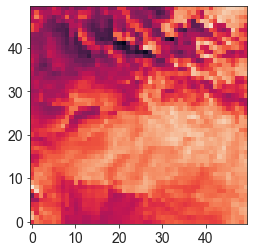

In [72]:
data = wind[0,:,:,0]
plt.imshow(data, origin="lower")

In [18]:
spacing = 8 # every 8th point is 16km resolution
cube = dset[::(24 * 30), y_range[0]:y_range[1]:spacing, x_range[0]:x_range[1]:spacing] # every 30 days

In [24]:
# Convert data cube to a datafame where each location is a column
ll_for_coords = wtk['coordinates'][y_range[0]:y_range[1]:spacing, x_range[0]:x_range[1]:spacing]
df = pd.DataFrame()
for i in range(len(ll_for_coords)):
    for j in range(len(ll_for_coords[i])):
        colname = "%.03f,%.03f" % (ll_for_coords[i][j][1], ll_for_coords[i][j][0])
        df[colname] = cube[:, i, j]

df.index = wtk["datetime"][::(24 * 30)]
df.index.name = 'datetime'
        
df.head()

,datetime,"-108.918,36.314","-108.738,36.337","-108.558,36.360","-108.377,36.383","-108.196,36.406","-108.016,36.428","-107.835,36.450","-107.654,36.471","-107.472,36.492",...,"-104.031,41.443","-103.834,41.458","-103.637,41.472","-103.439,41.486","-103.242,41.500","-103.044,41.513","-102.846,41.526","-102.648,41.538","-102.450,41.551","-102.252,41.562"
0,20070101000000,1.232948,1.629692,1.474045,2.407913,1.113922,1.477097,1.120026,1.962341,1.522873,...,5.334633,5.923645,6.982635,8.450577,8.066040,7.095551,7.397690,7.837151,8.795433,9.939880
1,20070131000000,4.055908,1.318398,0.811790,7.196266,9.112823,8.435318,8.874786,8.508560,4.971466,...,9.378342,9.118927,9.991760,10.074158,10.666222,8.908356,5.746635,5.627617,7.068085,7.889038
2,20070302000000,9.503464,7.907349,9.765923,8.896149,10.589920,11.215553,11.651970,11.789299,13.245033,...,14.334541,14.014099,14.267403,13.580734,15.317238,13.931702,17.725151,12.323372,4.898224,6.878876
3,20070401000000,9.631645,5.987732,6.930756,7.416000,8.182014,8.984650,9.555344,11.316261,11.999878,...,11.181984,9.933777,10.150459,9.353920,9.222694,11.053802,11.615341,11.389511,11.590927,13.138222
4,20070501000000,6.634727,7.165749,7.733391,7.300026,6.323433,4.367195,4.599136,5.560471,6.070129,...,5.648979,5.734428,8.044678,8.673363,8.844261,9.183022,9.054840,10.046692,10.013123,10.696739


In [25]:
df.to_csv("colorado_wtk-wspd.csv")

In [ ]:
wtk.close()

## National Solar Radiation Database (NSRDB)
### Single Multivariate Timeseries

In [34]:
nsrdb = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2017.h5", 'r')  
list(nsrdb)

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [35]:
LongsPeak_idx = NSRDB_idx(nsrdb, (40.2549, -105.6160))
LongsPeak_idx

152117

In [36]:
# function to unscale nsrdb timeseries
def unscale_dset(nsrdb, dset_name, idx):
    dset = nsrdb[dset_name]
    return dset[:, idx] / dset.attrs['psm_scale_factor']

In [37]:
%time df = pd.DataFrame({"wind_speed": unscale_dset(nsrdb, 'wind_speed', LongsPeak_idx),\
                         "wind_direction": unscale_dset(nsrdb, 'wind_direction', LongsPeak_idx),\
                         "dhi": unscale_dset(nsrdb, 'dhi', LongsPeak_idx),\
                         "dni": unscale_dset(nsrdb, 'dni', LongsPeak_idx)},\
                        index=nsrdb['time_index'][...].astype(str))
df.index.name = 'datetime'
df.head()

Wall time: 8.36 s


,wind_speed,wind_direction,dhi,dni
datetime,,,,
2017-01-01T00:00:00.000000000,1.0,273.9,0.0,0.0
2017-01-01T00:30:00.000000000,1.1,273.9,0.0,0.0
2017-01-01T01:00:00.000000000,1.2,271.9,0.0,0.0
2017-01-01T01:30:00.000000000,1.4,271.9,0.0,0.0
2017-01-01T02:00:00.000000000,1.6,269.1,0.0,0.0


In [38]:
# save data to csv
df.to_csv('longspeak_nsrdb.csv')

### Variable for a geographic region (State)

In [39]:
def metaForState(nsrdb, state):
    meta = pd.DataFrame(nsrdb['meta'][...])
    state = meta.loc[meta['state'] == str.encode(state)] # Note .h5 saves strings as bit-strings
    return state

# Extract all of Colorado
CO_sites = metaForState(nsrdb, 'Colorado')

In [40]:
print( "There are ...")
print( "  {} points within CO at 4km resolution".format(len(CO_sites)))
print( "  {} points within CO at 8km resolution".format(len(CO_sites[::2])))
print( "  {} points within CO at 16km resolution".format(len(CO_sites[::4])))

There are ...
  17500 points within CO at 4km resolution
  8750 points within CO at 8km resolution
  4375 points within CO at 16km resolution


In [50]:
# Map GHI for July 4th
time_index = pd.to_datetime(nsrdb['time_index'][...].astype(str))
timestep = np.where(time_index == '2017-07-04 20:00:00')[0][0]
dhi = nsrdb['dhi'][timestep][CO_sites.index] / nsrdb['dhi'].attrs['psm_scale_factor']
df = CO_sites[['longitude', 'latitude']].copy()
df['dhi'] = dhi

# df.plot.scatter(x='longitude', y='latitude', c='dhi',
#                 colormap='YlOrRd',
#                 title=str(time_index[timestep]))
# plt.show()

In [42]:
dhi.shape

NameError: name 'dhi' is not defined

In [51]:
dni = nsrdb['dni'][timestep][CO_sites.index] / nsrdb['dni'].attrs['psm_scale_factor']

In [ ]:
speed = nsrdb['wind_speed'][timestep][CO_sites.index] / nsrdb['wind_speed'].attrs['psm_scale_factor']
direction = nsrdb['wind_direction'][timestep][CO_sites.index] / nsrdb['wind_direction'].attrs['psm_scale_factor']

In [45]:
ua = np.multiply(speed, np.cos(np.radians(direction+np.pi/2)))
va = np.multiply(speed, np.sin(np.radians(direction+np.pi/2)))

In [46]:
ua.shape

(17500,)

In [61]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

def conv_layer_2d(x, filter_shape, stride, trainable=True):
    W = tf.get_variable(
        name='weight',
        shape=filter_shape,
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    b = tf.get_variable(
        name='bias',
        shape=[filter_shape[-1]],
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    x = tf.nn.bias_add(tf.nn.conv2d(
        input=x,
        filter=W,
        strides=[1, stride, stride, 1],
        padding='SAME'), b)

    return x

def deconv_layer_2d(x, filter_shape, output_shape, stride, trainable=True):
    x = tf.pad(x, [[0,0], [3,3], [3,3], [0,0]], mode='reflect')
    W = tf.compat.v1.get_variable(
        name='weight',
        shape=filter_shape,
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    b = tf.compat.v1.get_variable(
        name='bias',
        shape=[output_shape[-1]],
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    x = tf.nn.bias_add(tf.nn.conv2d_transpose(
        value=x,
        filter=W,
        output_shape=output_shape,
        strides=[1, stride, stride, 1],
        padding='SAME'), b)

    return x[:, 3:-3, 3:-3, :]

def flatten_layer(x):
    input_shape = x.get_shape().as_list()
    dim = input_shape[1] * input_shape[2] * input_shape[3]
    transposed = tf.transpose(x, (0, 3, 1, 2))
    x = tf.reshape(transposed, [-1, dim])

    return x

def dense_layer(x, out_dim, trainable=True):
    in_dim = x.get_shape().as_list()[-1]
    W = tf.get_variable(
        name='weight',
        shape=[in_dim, out_dim],
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer(stddev=0.02),
        trainable=trainable)
    b = tf.get_variable(
        name='bias',
        shape=[out_dim],
        dtype=tf.float32,
        initializer=tf.constant_initializer(0.0),
        trainable=trainable)
    x = tf.add(tf.matmul(x, W), b)

    return x

def pixel_shuffle_layer(x, r, n_split):
    def PS(x, r):
        N, h, w = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        x = tf.reshape(x, (N, h, w, r, r))
        x = tf.transpose(x, (0, 1, 2, 4, 3))
        x = tf.split(x, h, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x], 2)
        x = tf.split(x, w, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x], 2)
        x = tf.reshape(x, (N, h*r, w*r, 1))

    xc = tf.split(x, n_split, 3)
    x = tf.concat([PS(x_, r) for x_ in xc], 3)

    return x

def plot_SR_data(idx, LR, SR, path):

    for i in range(LR.shape[0]):
        vmin0, vmax0 = np.min(SR[i,:,:,0]), np.max(SR[i,:,:,0])
        vmin1, vmax1 = np.min(SR[i,:,:,1]), np.max(SR[i,:,:,1])

        plt.figure(figsize=(12, 12))

        plt.subplot(221)
        plt.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('LR 0 Input', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(223)
        plt.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('LR 1 Input', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(222)
        plt.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('SR 0 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(224)
        plt.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('SR 1 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.savefig(path+'/img{0:05d}.png'.format(idx[i]), dpi=200, bbox_inches='tight')
        plt.close()


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])

    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], x.shape[3]], dtype=tf.float64)
    downscaled = tf.nn.conv2d(x_in, filter=weight, strides=[1, K, K, 1], padding='SAME')

    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})

    return ds_out

def generate_TFRecords(filename, data, mode='test', K=None):
    '''
        Generate TFRecords files for model training or testing

        inputs:
            filename - filename for TFRecord (should by type *.tfrecord)
            data     - numpy array of size (N, h, w, c) containing data to be written to TFRecord
            model    - if 'train', then data contains HR data that is coarsened k times
                       and both HR and LR data written to TFRecord
                       if 'test', then data contains LR data
            K        - downscaling factor, must be specified in training mode

        outputs:
            No output, but .tfrecord file written to filename
    '''
    if mode == 'train':
        assert K is not None, 'In training mode, downscaling factor K must be specified'
        data_LR = downscale_image(data, K)

    with tf.python_io.TFRecordWriter(filename) as writer:
        print(data.shape)
        print(data[0])
        for j in range(data.shape[0]):
            if mode == 'train':
                h_HR, w_HR, c = data[j, ...].shape
                print(h_HR, w_HR, c)
                h_LR, w_LR, c = data_LR[j, ...].shape
                # print(f'HR Data: {data[j, ...]}')
                features = tf.train.Features(feature={
                                     'index': _int64_feature(j),
                                   'data_LR': _bytes_feature(data_LR[j, ...].tostring()),
                                      'h_LR': _int64_feature(h_LR),
                                      'w_LR': _int64_feature(w_LR),
                                   'data_HR': _bytes_feature(data[j, ...].tostring()),
                                      'h_HR': _int64_feature(h_HR),
                                      'w_HR': _int64_feature(w_HR),
                                         'c': _int64_feature(c)})
            elif mode == 'test':
                h_LR, w_LR, c = data[j, ...].shape
                features = tf.train.Features(feature={
                                     'index': _int64_feature(j),
                                   'data_LR': _bytes_feature(data[j, ...].tostring()),
                                      'h_LR': _int64_feature(h_LR),
                                      'w_LR': _int64_feature(w_LR),
                                         'c': _int64_feature(c)})
            # print(data[j, ...].shape)
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())
    writer.close()
solar_data = np.dstack([dni[:16000], dhi[:16000]])
solar = solar_data.reshape(10, 40, 40, 2)
generate_TFRecords('solar5.tfrecord', solar, mode='train', K=2)
# wind_data = np.dstack([ua[:16200], va[:16200]])
# wind = wind_data.reshape(2, 90, 90, 2)
# generate_TFRecords('wind12.tfrecord', wind, mode='train', K=1)

(10, 40, 40, 2)
[[[944. 118.]
  [945. 119.]
  [944. 118.]
  ...
  [905. 140.]
  [899. 143.]
  [898. 142.]]

 [[453. 484.]
  [448. 488.]
  [908. 136.]
  ...
  [342. 521.]
  [415. 517.]
  [418. 514.]]

 [[458. 491.]
  [547. 404.]
  [560. 394.]
  ...
  [938. 121.]
  [939. 121.]
  [937. 122.]]

 ...

 [[985.  99.]
  [981. 101.]
  [332. 513.]
  ...
  [958. 108.]
  [959. 108.]
  [960. 107.]]

 [[958. 109.]
  [960. 110.]
  [ 18. 283.]
  ...
  [182. 530.]
  [984. 102.]
  [299. 529.]]

 [[272. 591.]
  [268. 596.]
  [278. 587.]
  ...
  [931. 129.]
  [929. 131.]
  [930. 130.]]]
40 40 2
40 40 2
40 40 2
40 40 2
40 40 2
40 40 2
40 40 2
40 40 2
40 40 2
40 40 2
ipykernel_launcher:184: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
ipykernel_launcher:187: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [59]:
data = solar[0,:,:,0]

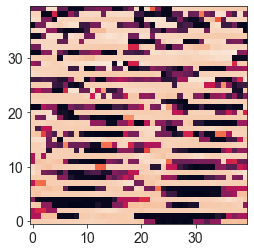

In [60]:
plt.imshow(data, origin="lower")

In [23]:
# Pull hourly ghi for every 4th site in CO:
df = pd.DataFrame()
for idx, row in CO_sites.iloc[::4].iterrows():
    lat_lon = '{:.2f}, {:.2f}'.format(*row[['latitude', 'longitude']].values)
    df[lat_lon] = unscale_dset(nsrdb, 'ghi', idx)[::2]

df.index = time_index[::2]
df.index.name = 'datetime'
df.head()

,"37.01, -109.02","37.01, -108.86","37.01, -108.70","37.01, -108.54","37.01, -108.38","37.01, -108.22","37.01, -108.06","37.01, -107.90","37.01, -107.74","37.01, -107.58",...,"40.61, -102.06","40.41, -102.06","38.53, -102.06","37.17, -102.06","39.69, -102.06","39.13, -102.06","38.49, -102.06","37.49, -102.06","38.37, -102.06","38.73, -102.06"
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Save to .csv
df.to_csv("colorado_nsrdb-ghi.csv")

In [24]:
nsrdb.close()